In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=400d8c6948b4bc42b4677f17aac3380fdedb8b775dfbc576c39048f1656a7db7
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
# Set paths to root, train, test and validation directories
_rootDir = '../input/braintumor/Brain/'
#os.listdir(_rootDir)
_trainDir = _rootDir + 'train/'
_valDir = _rootDir + 'validation/'
_testDir = _rootDir + 'test/'

In [ ]:
# Function to preprocess and store images and labels
def load(paths, verbose=-1):
    '''
        return:
            _imageList: A list of Images
            labels: A list of corresponding Labels
        args:
            paths: Path to main directory 
            * Must contain images belonging to a class as a single folder
    '''
    _imageList = list()
    _labelList = list()
    
    for (i, _imgPath) in enumerate(paths):
        
        img = cv2.imread(_imgPath, cv2.IMREAD_GRAYSCALE)
        # Set the desired height and weight of image data
        _dimensions = (32, 32)
        
        # resize image
        _image = cv2.resize(img, _dimensions, interpolation = cv2.INTER_AREA)
        numpyImage = np.array(_image).flatten()
        
        # rescale the image
        mupyImage = numpyImage/255
        label = _imgPath.split(os.path.sep)[-2]
        #print(label)
        
        _imageList.append(mupyImage)
        _labelList.append(label)
        
    # return a tuple of the _imageList and _labelList
    return _imageList, _labelList

In [ ]:
def one_hot_encoding(path):
    _path = list(paths.list_images(path))
    _data, _labelList = load(_path, verbose=10000)
    _lblzr = LabelBinarizer()
    _labels = _lblzr.fit_transform(_labelList)
    
    return _data, _labels

In [ ]:
# Preprocess training data
_trainX, _trainY = one_hot_encoding(_trainDir)
#print(len(_trainX))
#print(type(_trainY))

In [ ]:
# Preprocess validation and test data
_valX, _valY = one_hot_encoding(_valDir)

_testX, _testY = one_hot_encoding(_testDir)

In [ ]:
def create_clients(image_list, label_list, num_clients):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    _clientNames = []
    for i in range(num_clients):
        _client = '{}_{}'.format('client', i+1)
        _clientNames.append(_client)

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    
    _clientShards =[]
    for i in range(0, size*num_clients, size):
        _shard = data[i: i+size]
        _clientShards.append(_shard)
    
    #number of clients must equal number of shards
    if len(_clientShards) == len(_clientNames):
        _clientDict = {}
        for i in range(len(_clientNames)):
            _clientDict[_clientNames[i]] = _clientShards[i]
        return _clientDict
    else:
        return 0
    

In [ ]:
clients = create_clients(_trainX, _trainY, num_clients = 7)

In [ ]:
def batch_data(data_shard, bs=64):
    
    # Create tensorflow datasets from each client's data shards
    data, label = zip(*data_shard)
    #print("----------------"+str(type(data)))
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
# Create batches for training data
clients_batched = dict()

for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

2022-06-12 16:34:46.880743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:34:47.036815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:34:47.037877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 16:34:47.040779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((_testX, _testY)).batch(len(_testY))

#process and batch the test set  
val_batched = tf.data.Dataset.from_tensor_slices((_valX, _valY)).batch(len(_valY))

In [ ]:
# Define the hyperparameters
lr = 0.01 
_globalEpochs = 200
loss='categorical_crossentropy'
metrics = ['accuracy'] 
optimizer = SGD(lr=lr, 
                decay=lr / _globalEpochs, 
                momentum=0.9
               )   
activationFunction = "relu"

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Class for model architecture
class MLP:
    @staticmethod
    def _buildModel(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        #print(model.summary())
        return model

In [ ]:
def _globalAverageWeights(_localWeightList):
    _averageWeights = list()
    
    for _list in zip(*_localWeightList):
        _sum = tf.math.reduce_sum(_list, axis=0)
        _averageWeights.append(_sum)
        
    return _averageWeights

In [ ]:
def _getScalingFactor(_trainData, _clientName, _batchSize):
    
    _clients = list(_trainData.keys())
    
    #first calculate the total training data points across clinets
    _gblLength = list()
    _gblCount = 0
    
    for client in _clients:
        _length = tf.data.experimental.cardinality(_trainData[client]).numpy()
        _gblLength.append(_length)
        
    _gblCount = sum(_gblLength) * _batchSize

    # get the total number of data points held by a client
    _lclCount = tf.data.experimental.cardinality(_trainData[_clientName]).numpy()*_batchSize
    
    return _lclCount/_gblCount

In [ ]:
def _scaleWeights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)

    loss = cce(Y_test, logits)

    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
def _trainModel(_epochStep, _shallowLayers, _totalLayers):
    #initialize global model
    _globalObject = MLP()
    globalModel = _globalObject._buildModel(1024, 4)

    _globalAccuracy = list()
    _globalLoss = list()
    
    shallow_index = 2 * _shallowLayers
    total_index = 2 * _totalLayers
    #commence global training loop
    for _gEpoch in range(_globalEpochs):

        # get the global model's weights - will serve as the initial weights for all local models
        _globalWeights = globalModel.get_weights()

        #print(type(global_weights))
        global_deep_weights = _globalWeights[shallow_index:total_index]

        #initial list to collect local model weights after scalling
        _localWeightList = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        factor = 0
        #loop through each client and create new local model
        for client in client_names:
            _localObject = MLP()
            localModel = _localObject._buildModel(1024, 4)
            localModel.compile(loss=loss, 
                          optimizer=optimizer, 
                          metrics=metrics)


            #set local model weight to the weight of the global model
            localModel.set_weights(_globalWeights)

            #fit local model with client's data
            localModel.fit(clients_batched[client], epochs=10, verbose=0)
            lm = localModel.get_weights()

            if _gEpoch%_epochStep != 0:
                shallow_weights = lm[0:shallow_index]
                deep_weights = lm[shallow_index:total_index]
                comm_weights = shallow_weights
            else:
                comm_weights = lm

            #scale the model weights and add to list
            _scalingFactor = _getScalingFactor(clients_batched, client, 64)
            scaledWeights = _scaleWeights(comm_weights, _scalingFactor)

            #scaled_weights = _scaleLocalWeights(clients_batched,comm_weights, 64, client)
            _localWeightList.append(scaledWeights)
            factor = _scalingFactor

            #clear session to free memory after each communication round
            K.clear_session()

        globalScaledWeights = _scaleWeights(global_deep_weights, factor)

        if _gEpoch%_epochStep != 0:
            final_weights = list()
            for i in range(len(_localWeightList)):
                _weight = _localWeightList[i] + globalScaledWeights
                final_weights.append(_weight)

        else:
            final_weights = _localWeightList

        #to get the average over all the local model, we simply take the sum of the scaled weights
        #average_weights = sum_scaled_weights(scaled_local_weight_list)
        average_weights = _globalAverageWeights(final_weights)

        #update global model 
        globalModel.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_val, Y_val) in val_batched:
            global_acc, global_loss = test_model(X_val, Y_val, globalModel, _gEpoch)
            _globalAccuracy.append(global_acc)
            _globalLoss.append(global_loss)
        
    return globalModel,_globalAccuracy, _globalLoss
        

In [ ]:
def _visualise(_model,_acc, _loss):
    plt.plot(_acc)
    plt.plot(_loss)
    plt.title('Global Accuracy and Loss')
    plt.ylabel('Accuracy/Loss')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()

CASE 1: 
* Sharing deep weights every 5th epoch, 1 - shallow and 5 deep layers

In [ ]:
_case1Model, _case1Accuracy, _case1Loss  = _trainModel(5, 1, 6) 

2022-06-12 16:34:52.216671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


comm_round: 0 | global_acc: 54.167% | global_loss: 1.1883543729782104
comm_round: 1 | global_acc: 58.333% | global_loss: 1.1889395713806152
comm_round: 2 | global_acc: 58.333% | global_loss: 1.1745589971542358
comm_round: 3 | global_acc: 58.333% | global_loss: 1.1684376001358032
comm_round: 4 | global_acc: 64.583% | global_loss: 1.1466203927993774
comm_round: 5 | global_acc: 81.250% | global_loss: 1.0048632621765137
comm_round: 6 | global_acc: 79.167% | global_loss: 0.997678279876709
comm_round: 7 | global_acc: 77.083% | global_loss: 1.005008339881897
comm_round: 8 | global_acc: 77.083% | global_loss: 0.9790627360343933
comm_round: 9 | global_acc: 85.417% | global_loss: 0.9647335410118103
comm_round: 10 | global_acc: 85.417% | global_loss: 0.9083120822906494
comm_round: 11 | global_acc: 87.500% | global_loss: 0.8976901173591614
comm_round: 12 | global_acc: 89.583% | global_loss: 0.886121928691864
comm_round: 13 | global_acc: 91.667% | global_loss: 0.8695149421691895
comm_round: 14 | gl

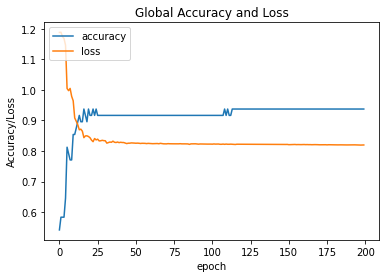

In [ ]:
_visualise(_case1Model, _case1Accuracy, _case1Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case1Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 93.983% | global_loss: 0.8053874373435974


CASE 2:
* Sharing deep weights every 10th epoch, 1 shallow and 5 deep layers

In [ ]:
_case2Model, _case2Accuracy, _case2Loss  = _trainModel(10, 1, 6) 

comm_round: 0 | global_acc: 22.917% | global_loss: 1.3782588243484497
comm_round: 1 | global_acc: 27.083% | global_loss: 1.3758293390274048
comm_round: 2 | global_acc: 27.083% | global_loss: 1.3724699020385742
comm_round: 3 | global_acc: 29.167% | global_loss: 1.3690649271011353
comm_round: 4 | global_acc: 31.250% | global_loss: 1.365211009979248
comm_round: 5 | global_acc: 31.250% | global_loss: 1.3612052202224731
comm_round: 6 | global_acc: 31.250% | global_loss: 1.3573662042617798
comm_round: 7 | global_acc: 31.250% | global_loss: 1.3538297414779663
comm_round: 8 | global_acc: 31.250% | global_loss: 1.3505610227584839
comm_round: 9 | global_acc: 33.333% | global_loss: 1.347437858581543
comm_round: 10 | global_acc: 54.167% | global_loss: 1.3056074380874634
comm_round: 11 | global_acc: 52.083% | global_loss: 1.2928736209869385
comm_round: 12 | global_acc: 52.083% | global_loss: 1.2826749086380005
comm_round: 13 | global_acc: 52.083% | global_loss: 1.2742666006088257
comm_round: 14 | g

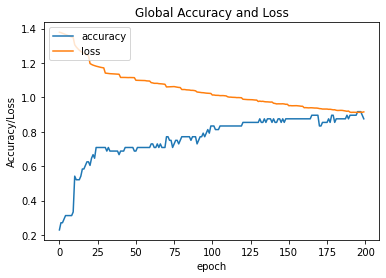

In [ ]:
_visualise(_case2Model, _case2Accuracy, _case2Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case2Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 90.182% | global_loss: 0.8632149696350098


CASE 3:
* Sharing deep weights every epoch, 1 shallow and 5 deep layers

In [ ]:
_case3Model, _case3Accuracy, _case3Loss  = _trainModel(1, 1, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3834480047225952
comm_round: 1 | global_acc: 25.000% | global_loss: 1.381602168083191
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3801072835922241
comm_round: 3 | global_acc: 29.167% | global_loss: 1.3771705627441406
comm_round: 4 | global_acc: 29.167% | global_loss: 1.3693915605545044
comm_round: 5 | global_acc: 47.917% | global_loss: 1.353023886680603
comm_round: 6 | global_acc: 50.000% | global_loss: 1.3296056985855103
comm_round: 7 | global_acc: 54.167% | global_loss: 1.3030422925949097
comm_round: 8 | global_acc: 60.417% | global_loss: 1.2750047445297241
comm_round: 9 | global_acc: 62.500% | global_loss: 1.2493287324905396
comm_round: 10 | global_acc: 64.583% | global_loss: 1.2226983308792114
comm_round: 11 | global_acc: 66.667% | global_loss: 1.2006739377975464
comm_round: 12 | global_acc: 66.667% | global_loss: 1.1790977716445923
comm_round: 13 | global_acc: 68.750% | global_loss: 1.1610463857650757
comm_round: 14 | g

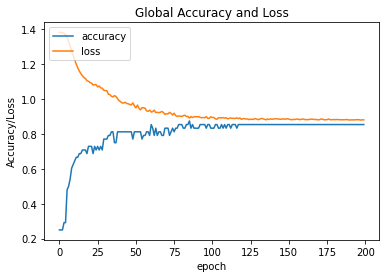

In [ ]:
_visualise(_case3Model, _case3Accuracy, _case3Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case3Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 92.795% | global_loss: 0.8157132863998413


CASE 4:
* Sharing deep weights every 5th epoch, 3 shallow and 3 deep layers

In [ ]:
_case4Model, _case4Accuracy, _case4Loss  = _trainModel(5, 3, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.381003975868225
comm_round: 1 | global_acc: 25.000% | global_loss: 1.3800230026245117
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3789525032043457
comm_round: 3 | global_acc: 25.000% | global_loss: 1.3782325983047485
comm_round: 4 | global_acc: 25.000% | global_loss: 1.3777891397476196
comm_round: 5 | global_acc: 27.083% | global_loss: 1.377062439918518
comm_round: 6 | global_acc: 27.083% | global_loss: 1.3754940032958984
comm_round: 7 | global_acc: 31.250% | global_loss: 1.372937798500061
comm_round: 8 | global_acc: 41.667% | global_loss: 1.3695111274719238
comm_round: 9 | global_acc: 43.750% | global_loss: 1.365317702293396
comm_round: 10 | global_acc: 47.917% | global_loss: 1.3592748641967773
comm_round: 11 | global_acc: 47.917% | global_loss: 1.3518222570419312
comm_round: 12 | global_acc: 50.000% | global_loss: 1.3445647954940796
comm_round: 13 | global_acc: 52.083% | global_loss: 1.3372231721878052
comm_round: 14 | glo

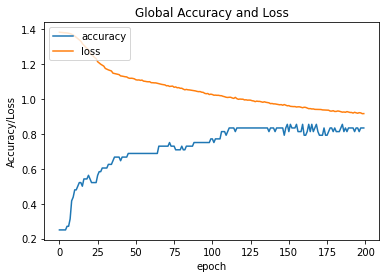

In [ ]:
_visualise(_case4Model, _case4Accuracy, _case4Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case4Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 90.420% | global_loss: 0.8526398539543152


CASE 5:
* Sharing deep weights every 10th epoch, 3 shallow and 3 deep layers

In [ ]:
_case5Model, _case5Accuracy, _case5Loss  = _trainModel(10, 3, 6) 

comm_round: 0 | global_acc: 31.250% | global_loss: 1.3828779458999634
comm_round: 1 | global_acc: 31.250% | global_loss: 1.3815914392471313
comm_round: 2 | global_acc: 31.250% | global_loss: 1.380374550819397
comm_round: 3 | global_acc: 31.250% | global_loss: 1.379428505897522
comm_round: 4 | global_acc: 33.333% | global_loss: 1.3785549402236938
comm_round: 5 | global_acc: 29.167% | global_loss: 1.3779693841934204
comm_round: 6 | global_acc: 29.167% | global_loss: 1.3776086568832397
comm_round: 7 | global_acc: 29.167% | global_loss: 1.377266526222229
comm_round: 8 | global_acc: 29.167% | global_loss: 1.3767293691635132
comm_round: 9 | global_acc: 29.167% | global_loss: 1.3760119676589966
comm_round: 10 | global_acc: 29.167% | global_loss: 1.3724604845046997
comm_round: 11 | global_acc: 29.167% | global_loss: 1.3714022636413574
comm_round: 12 | global_acc: 29.167% | global_loss: 1.3702524900436401
comm_round: 13 | global_acc: 29.167% | global_loss: 1.3690223693847656
comm_round: 14 | gl

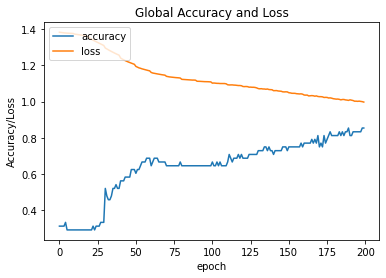

In [ ]:
_visualise(_case5Model, _case5Accuracy, _case5Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case5Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 85.194% | global_loss: 0.9249021410942078


CASE 6:
* Sharing deep weights every epoch, 3 shallow and 3 deep layers

In [ ]:
_case6Model, _case6Accuracy, _case6Loss  = _trainModel(1, 3, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.379707932472229
comm_round: 1 | global_acc: 25.000% | global_loss: 1.378203272819519
comm_round: 2 | global_acc: 25.000% | global_loss: 1.3765827417373657
comm_round: 3 | global_acc: 25.000% | global_loss: 1.3751741647720337
comm_round: 4 | global_acc: 22.917% | global_loss: 1.373552918434143
comm_round: 5 | global_acc: 22.917% | global_loss: 1.371939778327942
comm_round: 6 | global_acc: 29.167% | global_loss: 1.370370864868164
comm_round: 7 | global_acc: 33.333% | global_loss: 1.3688379526138306
comm_round: 8 | global_acc: 37.500% | global_loss: 1.36724054813385
comm_round: 9 | global_acc: 39.583% | global_loss: 1.365594506263733
comm_round: 10 | global_acc: 47.917% | global_loss: 1.3633695840835571
comm_round: 11 | global_acc: 52.083% | global_loss: 1.3600586652755737
comm_round: 12 | global_acc: 50.000% | global_loss: 1.355454444885254
comm_round: 13 | global_acc: 52.083% | global_loss: 1.3495036363601685
comm_round: 14 | global_a

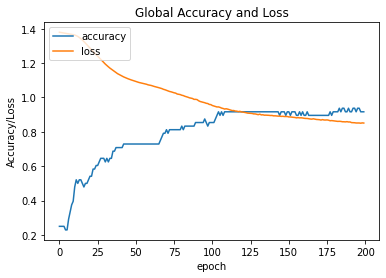

In [ ]:
_visualise(_case6Model, _case6Accuracy, _case6Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case6Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 91.449% | global_loss: 0.8399953246116638


CASE 7:
* Sharing deep weights every 5th epoch, 4 shallow and 2 deep layers

In [ ]:
_case7Model, _case7Accuracy, _case7Loss  = _trainModel(5, 4, 6) 

In [ ]:
_visualise(_case7Model, _case7Accuracy, _case7Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case7Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 8:
* Sharing deep weights every 10th epoch, 4 shallow and 2 deep layers

In [ ]:
_case8Model, _case8Accuracy, _case8Loss  = _trainModel(10, 4, 6) 

In [ ]:
_visualise(_case8Model, _case8Accuracy, _case8Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case8Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 9:
* Sharing deep weights every epoch, 4 shallow and 2 deep layers

In [ ]:
_case9Model, _case9Accuracy, _case9Loss  = _trainModel(1, 4, 6) 

In [ ]:
_visualise(_case9Model, _case9Accuracy, _case9Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case9Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)